In [1]:
# V2 Updates
# clean up custom function definitions
# make model loadable from other file

In [2]:
## LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model, Sequential
from keras.layers import Conv1D,MaxPooling1D,LSTM,BatchNormalization,Dropout,Input,Dense,Bidirectional,Activation,Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.backend import squeeze
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from scipy import stats

import random 
random.seed(123)

/Users/alezel/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#to display train and validation metrics on same tensorboard plot
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./tensorboard_logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [4]:
# define custom metrics
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true, name='pearson_r')
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'pearson_r'  in i.name.split('/')]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return pearson_r*abs(pearson_r)
    

In [5]:
# evaluations on test data 
def eval_on_test(X_test, Y_test, model, fname):
    loss = model.evaluate(X_test, Y_test)
    Y_pred = model.predict(X_test)
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(Y_test[:,0], Y_pred[:,0])
    x = Y_pred
    y = Y_test
    if fname:
        plt.plot(x, y, 'o', label='original data')
        plt.plot(x, intercept + slope*x, 'r', label='fitted line')
        plt.legend()
        plt.title('R2 = {}'.format(rvalue*abs(rvalue)))
        plt.xlabel('Y_pred')
        plt.ylabel('Y_true')
        plt.savefig(fname+'.pdf', bbox_inches='tight')
    return loss, rvalue*abs(rvalue)


In [6]:
import os
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

#setting default path if interactive mode (run this cell only ONCE if in interactive mode)
if is_interactive():
    os.chdir("../")
    

In [7]:
import configparser
import sys
from os.path import basename

#change only THESE
model_path = "./models/THIS_CNN_NN_vals_input.py"
data_path = "./data/THIS_data.npz"


weights_dir = "./weights"
results_dir = "./results"
model_name = os.path.splitext(basename(model_path))[0]
weight_path = os.path.join(weights_dir, model_name)
csv_logger_path = os.path.join(results_dir, model_name + "_val_results.csv")
test_results_path = os.path.join(results_dir, model_name + "_test_results.csv")

for filename in [weight_path, csv_logger_path, test_results_path]:
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
args = (sys.argv)
config_path = ""
if not is_interactive():
    model_path = args[1]
    config_path = args[2]
    weight_path = args[3]
    csv_logger_path = args[4]
    test_results_path = args[4] + "_testset"
    data_path = args[5]

suffix = "{epoch:03d}-{val_loss:.3f}.hdf5"
weight_model_path = "{}.{}".format(weight_path, suffix)


#hyperparameters    
DROPOUT = 0   # dropout
ALPHA = 0.01 # learnrate
BETA = 0.01
EPOCHS = 2 # epochs
MBATCH = 100 # batch size
SHUFFLE = True

#loading from config 
if not is_interactive():
    config_file = args[2]
    config = configparser.ConfigParser()
    config.read(config_file)
    ALPHA = config.getfloat('main', 'alpha')
    DROPOUT = config.getfloat('main', 'dropout')
    EPOCHS = config.getint('main', 'epochs')
    MBATCH = config.getint('main', 'mbatch')
    BETA = config.getfloat('main', 'beta')
    SHUFFLE = config.getboolean('main', 'SHUFFLE')

#loading model difinitions    
model_file = open(model_path, 'r').read()
exec(model_file)

In [8]:
#loading data
X_train, X_test, Y_train, Y_test = load_data(data_path)


In [9]:
input_shape = X_train[0].shape[1:3]
model = POC_model(input_shape, DROPOUT)
model.summary()


Loading model from disk..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 650, 4)       0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 641, 128)     5248        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 641, 128)     512         conv1d_6[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 641, 128)     0           batch_normalization_7[0][0]      
___________________________________________________________________________________

In [10]:
opt = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999, decay=BETA)
model.compile(loss='mse', optimizer=opt, metrics=[coeff_determination, correlation_coefficient, 'mse'])


In [11]:
# Set callbacks
# checkpoint
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/
# https://keras.io/callbacks/ - for now save every epoch

checkpoint = ModelCheckpoint(weight_model_path, monitor='val_loss', verbose=0, 
                             save_best_only=False, save_weights_only=False, mode='auto', period=1)

# tensorboard
# http://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

tensorboard = TrainValTensorBoard(write_graph=False, log_dir='./tensorboard_logs/' + \
                                  basename(data_path) + '_' + basename(csv_logger_path))

csv = CSVLogger(csv_logger_path, separator = ",", append = True)

callbacks_list = [checkpoint, tensorboard, csv]

# in terminal run: tensorboard --logdir=logs/
# val_loss error is in callbacks, probably modelcheckpoint

In [12]:
#checking if model exist then load best
import glob
import re

def find_best_model(all_models):
        epochs = []
        losses = []
        for i, file in enumerate(all_models):
            groups = re.findall(weight_path + '.(.*)-(.*).hdf5', file)
            if groups:
                epochs.append(int(groups[0][0]))
                losses.append(float(groups[0][1]))
        return (all_models[np.argmin(losses)] )

all_models = [os.path.join(os.path.dirname(weight_path), f) \
              for f in os.listdir(os.path.dirname(weight_path)) \
              if re.match(os.path.basename(weight_path) + '\.(.*)-(.*).hdf5', f)]


if all_models:
    best_model = find_best_model(all_models)
    print("Loading weights from {}".format(best_model))
    model.load_weights(best_model)


Loading weights from ./weights/THIS_CNN_NN_vals_input.008-0.391.hdf5


In [13]:
# keras model checkpoint KeyError: 'val_loss'
# fix: https://github.com/keras-team/keras/issues/6104
# must add validation_split=xx

model.fit(X_train, Y_train, batch_size=MBATCH, epochs=EPOCHS, validation_split=0.1, shuffle=SHUFFLE, callbacks=callbacks_list)

Train on 3605 samples, validate on 401 samples
Epoch 1/2
3605/3605 [==============================] - 8s 2ms/step - loss: 0.1648 - coeff_determination: 0.7908 - correlation_coefficient: nan - mean_squared_error: 0.1648 - val_loss: 0.4422 - val_coeff_determination: -5458.8088 - val_correlation_coefficient: 0.7853 - val_mean_squared_error: 0.4422
Epoch 2/2
3605/3605 [==============================] - 8s 2ms/step - loss: 0.1077 - coeff_determination: 0.8573 - correlation_coefficient: 0.7918 - mean_squared_error: 0.1077 - val_loss: 0.4421 - val_coeff_determination: -8158.0276 - val_correlation_coefficient: 0.8066 - val_mean_squared_error: 0.4421


446/446 [==============================] - 0s 690us/step


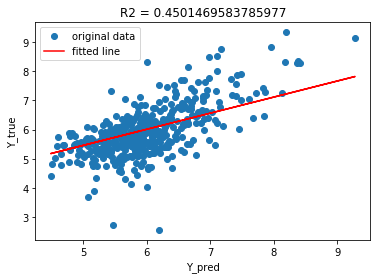

In [14]:
# tests data on test set 
test_loss, test_r2 = eval_on_test(X_test, Y_test, model, test_results_path)


In [15]:
# Save test results
d = {'coeff_determination' : [test_loss[1]], 
     'correlation_coefficient' : [test_loss[2]],
     'loss' : [test_loss[3]],
     'mean_squared_error' : [test_loss[0]],
     'R2_scipy_stats' : [test_r2]}

test_df = pd.DataFrame(data=d)
test_df.to_csv(test_results_path, index=False)
